# AI 4 StoryLines - GP + MAP

In this example, we are going to showcase how we can do sensitivity analysis using a simple linear regression model.

In [1]:
import autoroot
import arviz as az
import numpyro
import numpy as np
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import jax
import jax.random as jrandom
import jax.numpy as jnp
from jaxtyping import Array, Float
from pathlib import Path
from dataclasses import dataclass
import xarray as xr
import pandas as pd
import einops
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from bayesevt._src.utils.io import get_list_filenames
from utils import plot_weights
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
rng_key = jrandom.PRNGKey(123)

We can see that there is some explained variance that is missing.
Potentially we can explain this with the regression model.

## Load Data

We have a clean analysis-ready dataset available from the previous notebook.
We will save it and revisit it later.

First, we will make sure that the models in the covariates and the QoI are the same.

In [3]:
save_dir = "/pool/usuarios/juanjohn/data/ai4storylines/analysis/"

In [4]:
# load covariates
df = pd.read_csv(Path(save_dir).joinpath("covariates.csv"), index_col=0)
# load qoi
ds = xr.open_dataset(Path(save_dir).joinpath("qoi.nc"), engine="netcdf4")
# quick check
assert df.model.values.sort() == ds.model.values.sort()

ds = ds.stack(spatial=["lat", "lon"])
ds

<xarray.Dataset> Size: 57kB
Dimensions:    (model: 28, spatial: 399)
Coordinates:
  * model      (model) <U16 2kB 'access_cm2' 'access_esm1_5' ... 'ukesm1_0_ll'
    land_mask  (spatial) int16 798B 0 0 0 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0
  * spatial    (spatial) object 3kB MultiIndex
  * lat        (spatial) float64 3kB 26.25 26.25 26.25 ... 71.25 71.25 71.25
  * lon        (spatial) float64 3kB -20.0 -17.5 -15.0 -12.5 ... 25.0 27.5 30.0
Data variables:
    tasmax     (model, spatial) float32 45kB 3.244 2.818 2.714 ... 8.945 8.988
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.5 (https://mpi...
    source:                 ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\na...
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    ...                     ...
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/9ecf99bf-2241-4c6a-acea-15d12be52c43
    license:                CMIP6 model data produced by CSIRO is licensed un...
    CDO:                    Climate Data Operators version 2.0.5 (https://mpi...

## Baseline Model - Linear Regression

#### Input Data

In [5]:
covariate_names = ["sst", "sm_sur", "t2m", "z500_zonal"]
qoi_names = ["tasmax"]
x = df.sort_values(by=["model"])[covariate_names].values
u = ds.sortby("model").tasmax.values

In [6]:
x.shape, u.shape

((28, 4), (28, 399))

We see that we have the `4` covariates and the `19x21` grid points.

Linear Regression only works with a 1D vector. 
So we need to flatten the `u` variable.

In [7]:
x_coords = jnp.linspace(0, 1, ds.unstack().lon.shape[0])
y_coords = jnp.linspace(0, 1, ds.unstack().lat.shape[0])
X_coords, Y_coords = jnp.meshgrid(x_coords, y_coords, indexing="ij")
s_coords = jnp.stack([X_coords.ravel(), Y_coords.ravel()], axis=1)
s_coords.shape

(399, 2)

#### Model

In [8]:
num_spatial = u.shape[1]
num_models = u.shape[0]
num_covariates = x.shape[1]

In [9]:
u.shape

(28, 399)

In [10]:
from models import gram, kernel_rbf, model_gp, model_gp

In [11]:
K = gram(kernel_rbf, s_coords, s_coords, 0.1, 0.1)

In [12]:
rng_key, prior_key = jrandom.split(rng_key, 2)

In [25]:
prior_predictive = Predictive(model_gp, num_samples=2_000)
prior_samples = prior_predictive(prior_key, x=x, S=s_coords, )
# prior_samples

In [14]:
prior_samples["bias"].shape
prior_samples["weight"].shape

(2000, 4, 399)

### Sampling: MCMC

In [15]:
# initialize kernel
nuts_kernel = NUTS(model_gp)

# initial mcmc scheme
num_warmup = 500
num_samples = 2_000
num_chains = 3
mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

In [16]:
rng_key, model_key = jrandom.split(rng_key, 2)

In [17]:
%%time

mcmc.run(rng_key=model_key, x=x, S=s_coords, y=u)

/home/juanjohn/miniconda/envs/bayesevt_ai/lib/python3.10/site-packages/jax/_src/linear_util.py:192: UserWarning: We will disable progress bar because it does not work yet on multi-GPUs platforms.
  ans = self.f(*args, **dict(self.params, **kwargs))


CPU times: user 2h 21min 32s, sys: 4.41 s, total: 2h 21min 36s
Wall time: 52min 4s


### Posterior Samples

In [69]:
rng_key, post_key = jrandom.split(rng_key, 2)

In [70]:
posterior_predictive = Predictive(model_gp, posterior_samples=mcmc.get_samples())
posterior_samples = posterior_predictive(post_key, x=x, S=s_coords)

In [71]:
mcmc.get_samples()["weight"].shape

(6000, 4, 399)

In [72]:
import arviz as az
import numpy as np

mcmc_arviz = az.from_numpyro(
    posterior=mcmc, 
    coords = {"chain": np.arange(0, num_chains),
              "draw": np.arange(0, num_samples),
              # "spatial": pd.MultiIndex.from_arrays([lat, lon], names=["lat", "lon"]),
              "covariate": ["sst", "sm", "t2m", "z500"],
              "model": ds.model,
             },
    dims = {
        "bias": ["spatial"],
        "weight": [ "covariate", "spatial",],
        "obs": ["model", "spatial"],
        "z": ["model", "spatial"]

    },
    posterior_predictive=posterior_samples,
    # prior=prior_samples
)
    # prior=prior_samples, 
    # posterior_predictive=posterior_samples,

# assign the lat-lon coordinates to data structure
mcmc_arviz = mcmc_arviz.assign_coords({
    "spatial": ds[["lat", "lon"]].spatial,
    "lon": ds[["lat", "lon"]].lon,
    "lat": ds[["lat", "lon"]].lat,
})
# az.plot_trace(mcmc_arxiv, compact=True, figsize=(10, 5));
# plt.tight_layout()
mcmc_arviz

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [6]:
results_save_dir = "/pool/usuarios/juanjohn/data/ai4storylines/results/"

In [74]:
mcmc_arviz.unstack().to_netcdf(Path(results_save_dir).joinpath("gp_mcmc.nc"), engine="netcdf4")

PermissionError: [Errno 13] Permission denied: '/pool/usuarios/juanjohn/data/ai4storylines/results/gp_mcmc.nc'

### Load Data

In [7]:
mcmc_arviz_posterior = xr.open_dataset(Path(results_save_dir).joinpath("gp_mcmc.nc"), group="posterior")
mcmc_arviz_predictions = xr.open_dataset(Path(results_save_dir).joinpath("gp_mcmc.nc"), group="posterior_predictive")



In [8]:
from sklearn.metrics import r2_score

In [9]:
chain = 0

In [10]:
mcmc_arviz_predictions = mcmc_arviz_predictions.stack(spatial=["lat", "lon"])
pred = mcmc_arviz_predictions.obs.mean(["draw"]).sel(chain=chain)
true = ds.tasmax
score = r2_score(true.values, pred.values, multioutput="raw_values")
mcmc_arviz_predictions["score"] = (("spatial"), score)
mcmc_arviz_predictions = mcmc_arviz_predictions.unstack()

### Post-Model Analysis

We can extract the parameters for the regression model.
The coefficient corresponds to the slope of the regression model.

We want to plot the coefficient for each of the variables.
First, we need to reshape the 1D Vector to be a `lat-lon` vector.

## Analysis Dataset

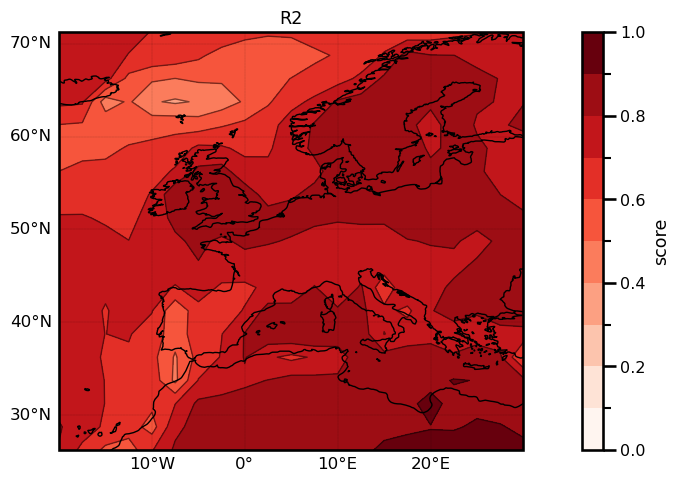

In [11]:
plot_weights(
    mcmc_arviz_predictions.score.unstack(), 
    "R2", vmin=0.0, vmax=0.99, cmap="Reds", num_levels=10
);

In [14]:
vmin = -2.0
vmax = 2.0
chain = 0
import numpy as np

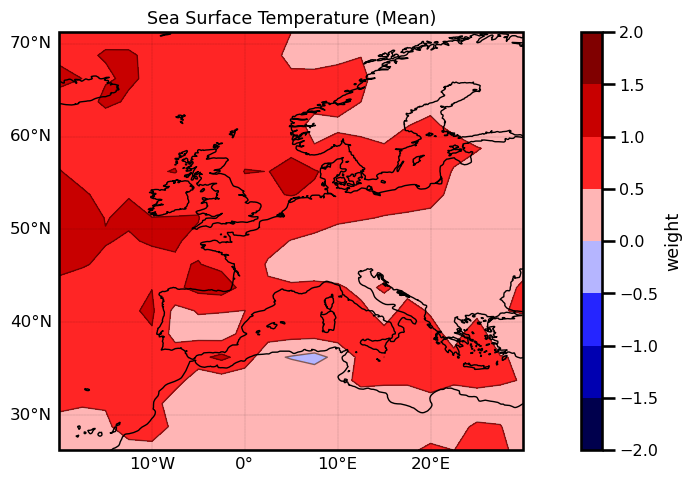

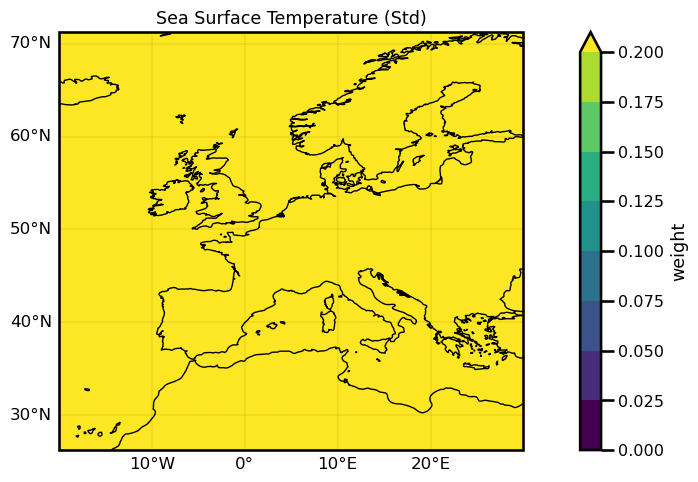

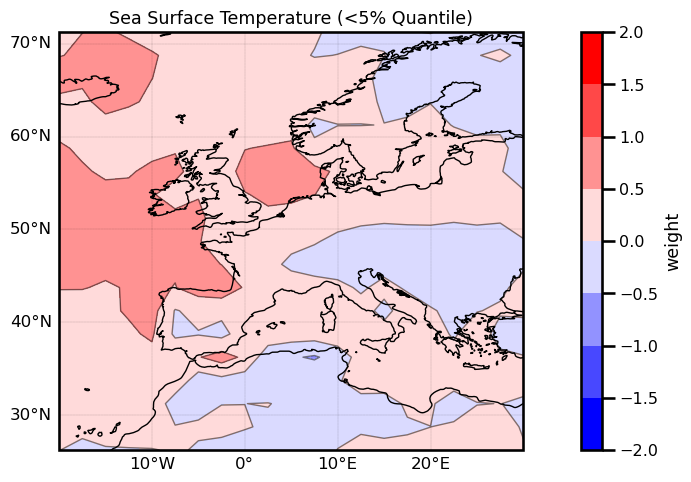

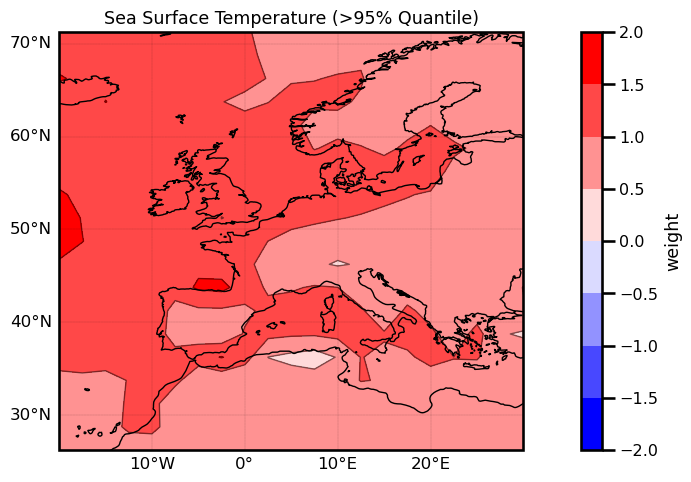

In [15]:
# Sea Surface Temperature
plot_weights(
    mcmc_arviz_posterior.weight.sel(covariate="sst", chain=chain).mean(["draw"], keep_attrs=True).unstack(), 
    "Sea Surface Temperature (Mean)", vmin=-2.0, vmax=2.0, cmap="seismic", num_levels=8
);
plot_weights(
    mcmc_arviz_posterior.weight.sel(covariate="sst", chain=chain).std(["draw"], keep_attrs=True).unstack(), 
    "Sea Surface Temperature (Std)", vmin=0.0, vmax=0.2, cmap="viridis"
);
plot_weights(
    mcmc_arviz_posterior.weight.sel(chain=chain, covariate="sst").quantile(q=0.05, dim=["draw"], keep_attrs=True).unstack(),
    r"Sea Surface Temperature (<5% Quantile)", vmin=-2.0, vmax=2.0
);
plot_weights(
    mcmc_arviz_posterior.weight.sel(chain=chain, covariate="sst").quantile(q=0.95, dim=["draw"], keep_attrs=True).unstack(),
    "Sea Surface Temperature (>95% Quantile)", vmin=-2.0, vmax=2.0);


#### Soil Moisture

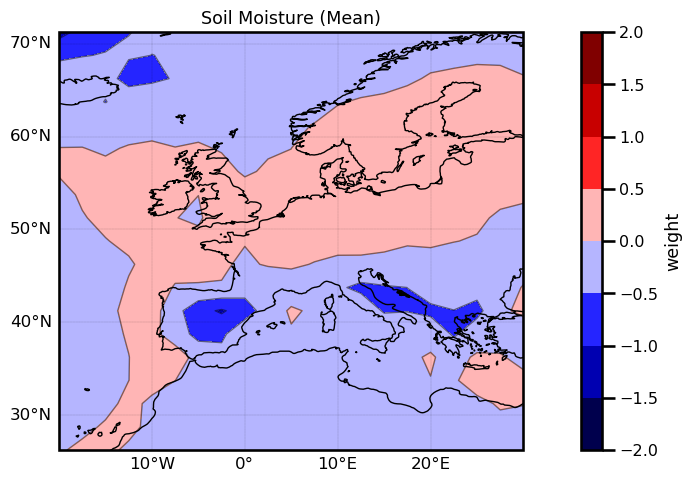

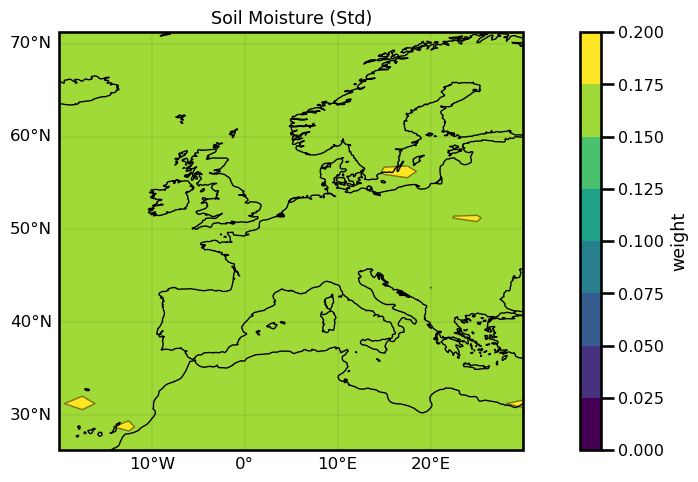

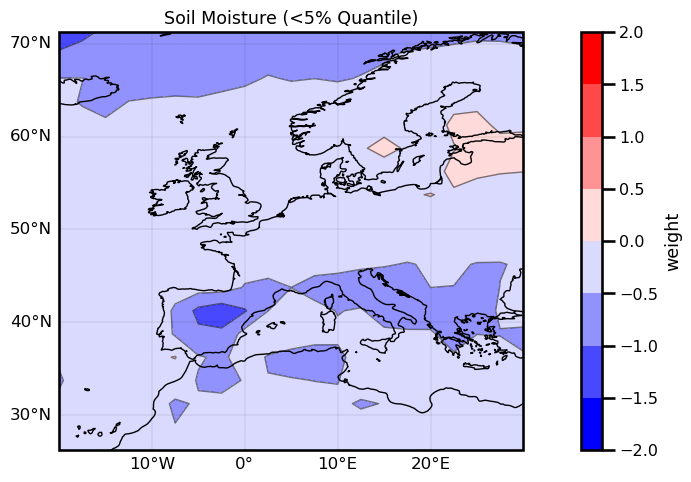

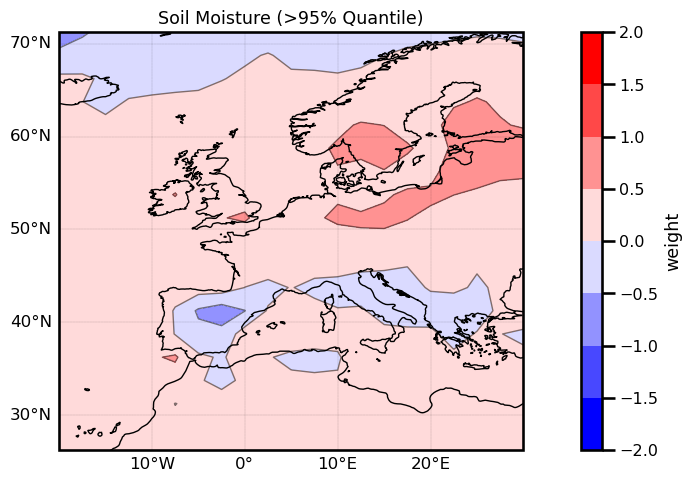

In [16]:
plot_weights(
    mcmc_arviz_posterior.weight.sel(covariate="sm", chain=chain).mean(["draw"], keep_attrs=True).unstack(), 
    "Soil Moisture (Mean)", vmin=-2.0, vmax=2.0, cmap="seismic", num_levels=8
);
plot_weights(
    mcmc_arviz_posterior.weight.sel(covariate="sm", chain=chain).std(["draw"], keep_attrs=True).unstack(), 
    "Soil Moisture (Std)", vmin=0.0, vmax=0.2, cmap="viridis"
);
plot_weights(
    mcmc_arviz_posterior.weight.sel(chain=chain, covariate="sm").quantile(q=0.05, dim=["draw"], keep_attrs=True).unstack(),
    r"Soil Moisture (<5% Quantile)", vmin=-2.0, vmax=2.0
);
plot_weights(
    mcmc_arviz_posterior.weight.sel(chain=chain, covariate="sm").quantile(q=0.95, dim=["draw"], keep_attrs=True).unstack(),
    "Soil Moisture (>95% Quantile)", vmin=-2.0, vmax=2.0);

#### 2M Temperature

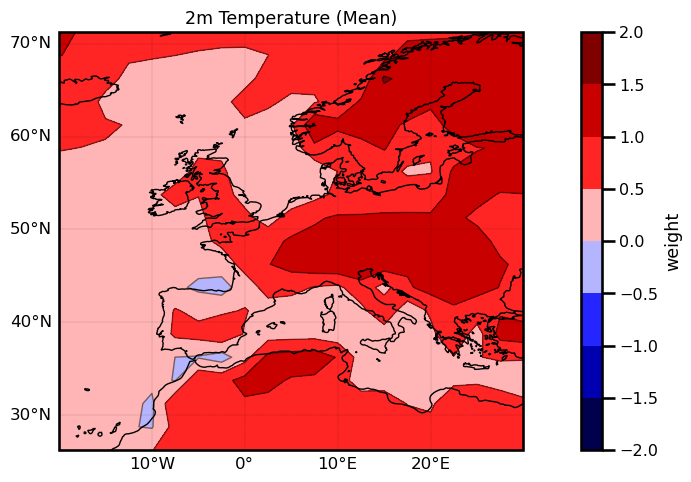

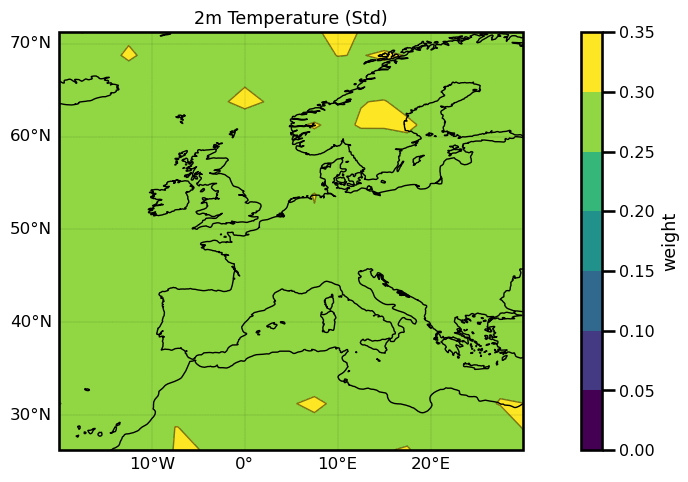

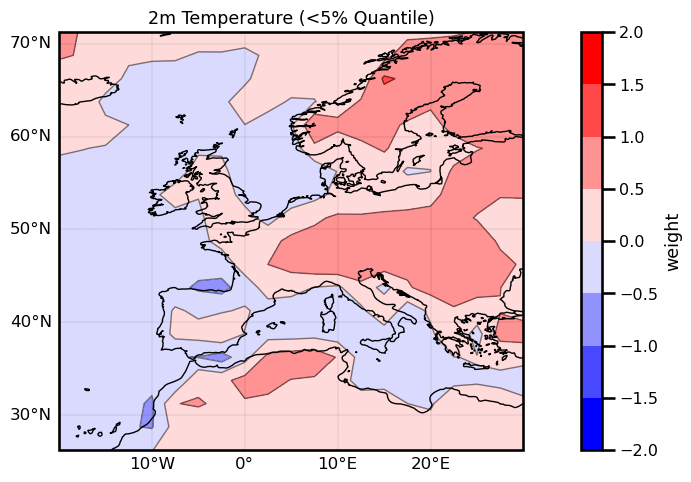

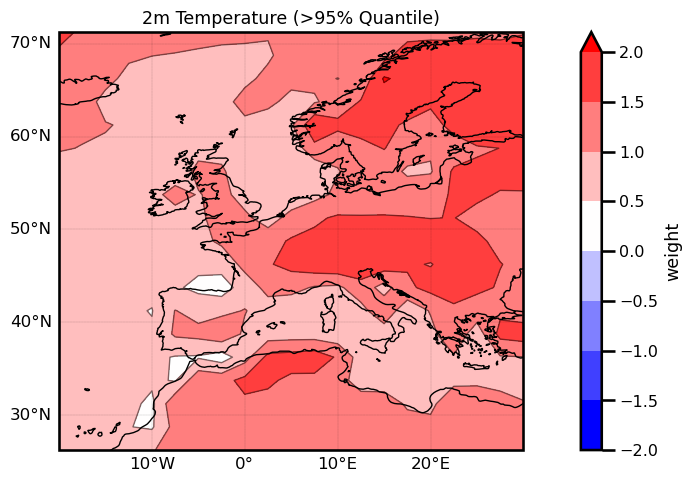

In [18]:
plot_weights(
    mcmc_arviz_posterior.weight.sel(covariate="t2m", chain=chain).mean(["draw"], keep_attrs=True).unstack(), 
    "2m Temperature (Mean)", vmin=-2.0, vmax=2.0, cmap="seismic", num_levels=8
);
plot_weights(
    mcmc_arviz_posterior.weight.sel(covariate="t2m", chain=chain).std(["draw"], keep_attrs=True).unstack(), 
    "2m Temperature (Std)", vmin=0.0, vmax=0.35, cmap="viridis"
);
plot_weights(
    mcmc_arviz_posterior.weight.sel(chain=chain, covariate="t2m").quantile(q=0.05, dim=["draw"], keep_attrs=True).unstack(),
    r"2m Temperature (<5% Quantile)", vmin=-2.0, vmax=2.0
);
plot_weights(
    mcmc_arviz_posterior.weight.sel(chain=chain, covariate="t2m").quantile(q=0.95, dim=["draw"], keep_attrs=True).unstack(),
    "2m Temperature (>95% Quantile)", vmin=-2.0, vmax=2.0);


#### Geopotential

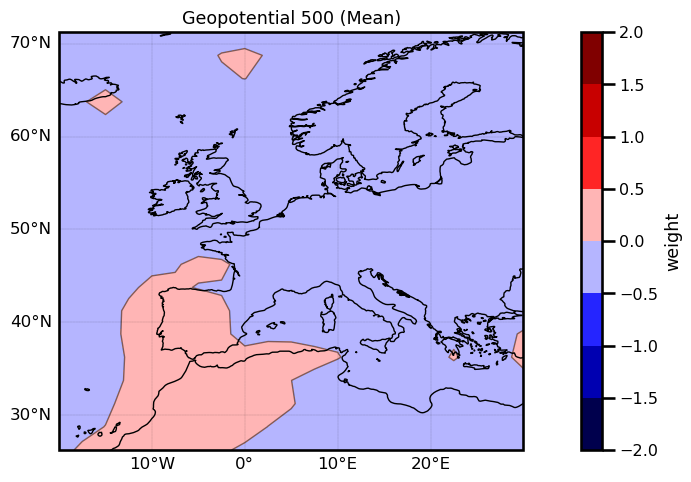

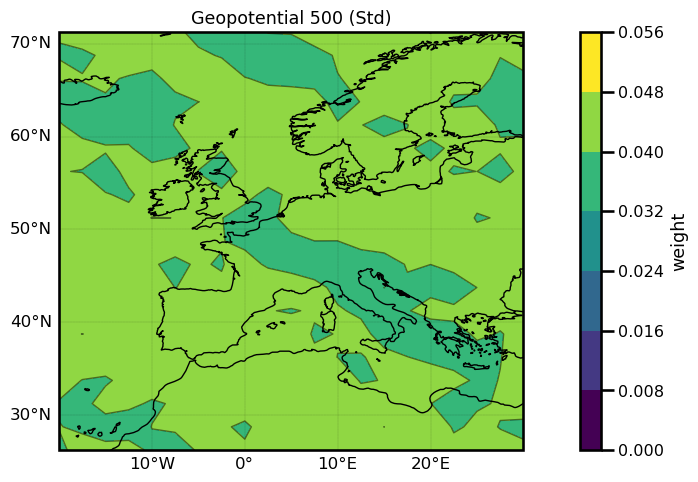

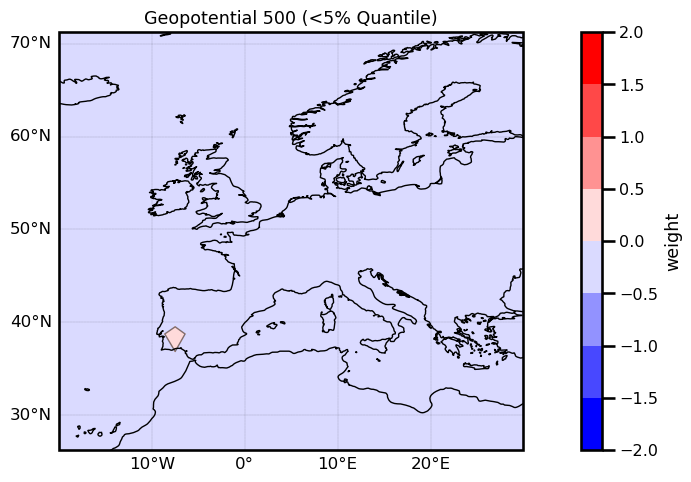

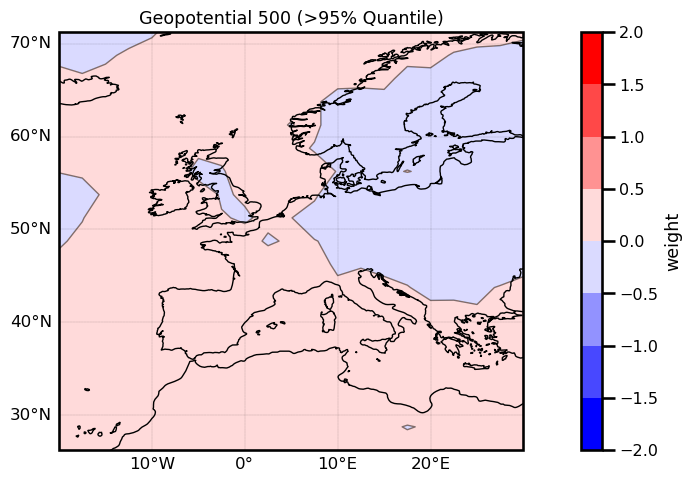

In [19]:
plot_weights(
    mcmc_arviz_posterior.weight.sel(covariate="z500", chain=chain).mean(["draw"], keep_attrs=True).unstack(), 
    "Geopotential 500 (Mean)", vmin=-2.0, vmax=2.0, cmap="seismic", num_levels=8
);
plot_weights(
    mcmc_arviz_posterior.weight.sel(covariate="z500", chain=chain).std(["draw"], keep_attrs=True).unstack(), 
    "Geopotential 500 (Std)", vmin=0.0, vmax=0.05, cmap="viridis"
);
plot_weights(
    mcmc_arviz_posterior.weight.sel(chain=chain, covariate="z500").quantile(q=0.05, dim=["draw"], keep_attrs=True).unstack(),
    r"Geopotential 500 (<5% Quantile)", vmin=-2.0, vmax=2.0
);
plot_weights(
    mcmc_arviz_posterior.weight.sel(chain=chain, covariate="z500").quantile(q=0.95, dim=["draw"], keep_attrs=True).unstack(),
    "Geopotential 500 (>95% Quantile)", vmin=-2.0, vmax=2.0);


## Things to Do


* Standardize Input/Output Data (see [sklearn.preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing))
* Find the Best Parameters with Cross Validation
* Choose a Better Linear Model ([LASSO](https://scikit-learn.org/stable/modules/linear_model.html#lasso), [LARS](https://scikit-learn.org/stable/modules/linear_model.html#least-angle-regression), [Elastic-Net](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net), [Generalized Linear Model](https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-models), [Quantile Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html#sklearn.linear_model.QuantileRegressor))